# Predicting acceleration time series from strain data

### Introduction
This notebook presents a method to predict the acceleration at 8 different locations on a 38 m long model riser. The accelerations are measured by accelerometers in both in-line and cross-flow direction.

Strain measurements on 24 locations CF and 40 locations IL are used as input to the prediction model

The accelerations are predicted in each step using a RNN model.

In [16]:
import scipy.io
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, TimeDistributed, Dropout, MaxPooling1D, MaxPooling2D, Conv2D, Input, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from scipy.stats import kurtosis, skew
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import itertools
from tensorflow.keras import regularizers

### Loading information text file

In [17]:
text_df = pd.read_csv("TD_CONDITIONSET_uniform_3D.txt", delimiter = "\t", header=None)
text = text_df.values

### Preparation of data

First the time vector is generated. The experiments were done with a sampling frequency of 1200 Hz. The initial part and the last part of the data is discarded as it is loaded in. 

The location of the sensors in meters are also included.

The location of the maximum value of the strain is found in CF and IL for each time step.


In [47]:
list_inputs = []
list_outputs = []
for i in range(0,22):
    
    file = os.path.join("Data", f"test{int(text[i,0])}.mat")
    mat = scipy.io.loadmat(file)

    chan_names = mat['chan_names']
    data = mat['data']
    
    D = 0.027 # Riser diameter
    U =  text[i,1]
    C = U**2/D
    
    # Time parameters
    t1 = text[i,10] # Start time
    t2 = text[i,11] # End time
    Fs = 1200 # Sampling freq
    dt = 1/Fs # Time step
    tst = int(t1*Fs) # Index for start
    ted = int(t2*Fs) # Index for end

    # Making a time vector
    nm = data.shape[1]
    time = np.arange(0,nm-1)*dt
    time = time[tst:ted].reshape(1,-1)

    # Defining feature vectors and cropping them from initial/end effects
    strain_CF = data[46:70,tst:ted]
    strain_CF_names = chan_names[46:70]
    strain_IL = data[6:46,tst:ted]
    strain_IL_names = chan_names[6:46]
    pos_IL = data[98:106,tst:ted] / D
    pos_CF = data[106:114,tst:ted] / D
    acc_IL = data[70:78,tst:ted] / C
    acc_IL_names = chan_names[70:78]
    acc_CF = data[78:86,tst:ted] / C
    acc_CF_names = chan_names[78:86]
    mean_force = data[95:97,tst:ted].mean(axis=0)

    # Strain sensor positions
    str_il = np.array([1.143,2.555,3.084,3.224,4.155,5.759,6.030,7.664,8.216,8.609,8.889,9.703,10.285,13.676,13.772,
                         15.393,16.452,16.547,16.891,19.997,20.193,21.393,21.603,22.460,23.165,25.153,25.442,26.254,27.532,
                         28.698,28.863,29.365,31.191,31.415,32.796,33.005,35.549,36.559,36.824,37.322])
    str_sensor_cf = np.array([2,3,4,5,7,10,11,13,14,17,19,20,21,22,24,25,26,28,31,32,33,36,38,40])-1
    str_cf = str_il[str_sensor_cf]

    # Accelerometer positions
    acc_pos = np.array([4.155,8.609,13.676,16.891,21.393,25.153,28.863,33.005])

    # Finding indices for strain locations which will be fused 
    sensor_diff_il = np.abs(np.tile(str_il,(8,1)).T - acc_pos)
    sensor_transform_index_il = np.argmin(sensor_diff_il,axis=1)
    sensor_diff_cf = np.abs(np.tile(str_cf,(8,1)).T - acc_pos)
    sensor_transform_index_cf = np.argmin(sensor_diff_cf,axis=1)

    # Find maximum strain locations for each time step
    max_strain_CF = strain_CF.argmax(axis=0)
    max_strain_CF_loc = str_cf[max_strain_CF]

    Xi = np.vstack((time,strain_IL,strain_CF)).transpose()
    Yi = np.vstack((acc_IL,acc_CF)).transpose()

    b_size = 200
    n_batches = Xi.shape[0]//b_size

    if not n_batches == 0:
        n_batches = Xi.shape[0] // b_size
        Xi = Xi[:n_batches*b_size,:]
        Yi = Yi[:n_batches*b_size,:]

    n_features = Xi.shape[1]
    n_outputs = Yi.shape[1]

    Xi = Xi.reshape(n_batches,b_size,n_features)
    Yi = Yi.reshape(n_batches,b_size,n_outputs)
    
    list_inputs.append(Xi)
    list_outputs.append(Yi)

X = np.concatenate(([list_inputs[i] for i in range(0,22)]),axis=0)
Y = np.concatenate(([list_outputs[i] for i in range(0,22)]),axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=1, shuffle=False)

t_train = X_train[:,:,0]
t_val = X_val[:,:,0]
t_test = X_test[:,:,0]
X_train = X_train[:,:,1:]
X_test = X_test[:,:,1:]
X_val = X_val[:,:,1:]

n_features = n_features-1

print(f'X-train: (batches, time steps in batch, features) = {X_train.shape}')
print(f'Y-train: (batches, time steps in batch, output)   = {y_train.shape}')
print(f'X-valid: (batches, time steps in batch, features) = {X_val.shape}')
print(f'Y-valid: (batches, time steps in batch, output)   = {y_val.shape}')
print(f'X-test : (batches, time steps in batch, features) = {X_test.shape}')
print(f'Y-test : (batches, time steps in batch, output)   = {y_test.shape}')

X-train: (batches, time steps in batch, features) = (3051, 200, 64)
Y-train: (batches, time steps in batch, output)   = (3051, 200, 16)
X-valid: (batches, time steps in batch, features) = (1503, 200, 64)
Y-valid: (batches, time steps in batch, output)   = (1503, 200, 16)
X-test : (batches, time steps in batch, features) = (1518, 200, 64)
Y-test : (batches, time steps in batch, output)   = (1518, 200, 16)


### Correlation between strain and acceleration

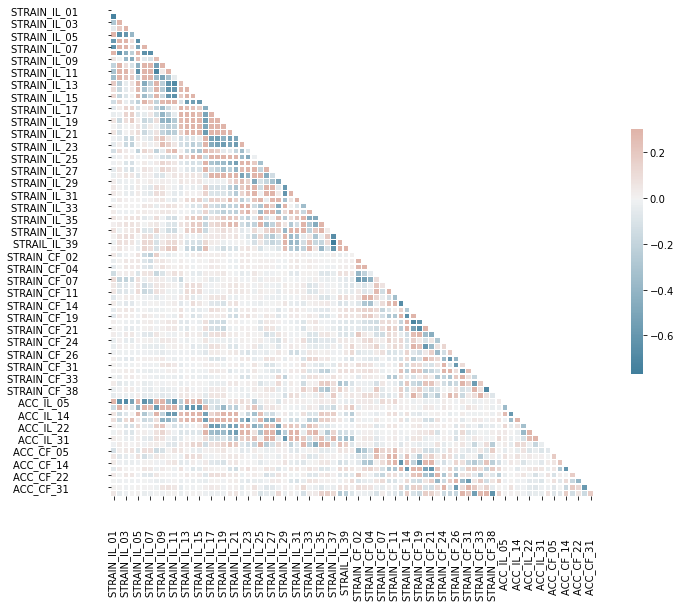

In [48]:
input_output_data = np.vstack((strain_IL,strain_CF,acc_IL,acc_CF)).transpose()
input_output_names = np.hstack((strain_IL_names,strain_CF_names,acc_IL_names,acc_CF_names))
d = pd.DataFrame(data=input_output_data,columns=input_output_names)
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Building RNN model

This model will use sparse_categorical_crossentropy, which means that if the true output can be $n \in 0:N$ different integers, then the prediction will be an array of size $N+1$ where each unit indicates a probability of the index.


In [49]:
# Regression
model = Sequential(name='LSTM')
model.add(LSTM(
    units=100,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True,
    dropout=0.1,
    recurrent_dropout=0.1,
    activation='tanh',
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(LSTM(
    units=100,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True,
    dropout=0.1,
    recurrent_dropout=0.1,
    activation='tanh',
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dense(50,
    activation='tanh',
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dropout(0.2))
model.add(Dense(n_outputs, activation='linear'))

model.summary()
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mean_squared_error'])

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200, 100)          66000     
_________________________________________________________________
lstm_5 (LSTM)                (None, 200, 100)          80400     
_________________________________________________________________
dense_4 (Dense)              (None, 200, 50)           5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 200, 16)           816       
Total params: 152,266
Trainable params: 152,266
Non-trainable params: 0
_________________________________________________________________


### Training model

Using an early stopping criteria.

Can continue training for a max of 100 epochs.

Validation data is used at each epoch.

In [50]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train,y_train,epochs=100,callbacks=callback,validation_data=(X_val, y_val),validation_steps=10,verbose=True)

Epoch 1/100
96/96 [==============================] - 82s 822ms/step - loss: 0.3286 - mean_squared_error: 0.2598 - val_loss: 0.2702 - val_mean_squared_error: 0.2082
Epoch 2/100
96/96 [==============================] - 80s 836ms/step - loss: 0.1897 - mean_squared_error: 0.1335 - val_loss: 0.2214 - val_mean_squared_error: 0.1703
Epoch 3/100
96/96 [==============================] - 84s 873ms/step - loss: 0.1614 - mean_squared_error: 0.1143 - val_loss: 0.2023 - val_mean_squared_error: 0.1589
Epoch 4/100
96/96 [==============================] - 91s 949ms/step - loss: 0.1467 - mean_squared_error: 0.1062 - val_loss: 0.1905 - val_mean_squared_error: 0.1527
Epoch 5/100
96/96 [==============================] - 85s 883ms/step - loss: 0.1366 - mean_squared_error: 0.1011 - val_loss: 0.1833 - val_mean_squared_error: 0.1500
Epoch 6/100
96/96 [==============================] - 91s 946ms/step - loss: 0.1293 - mean_squared_error: 0.0978 - val_loss: 0.1768 - val_mean_squared_error: 0.1471
Epoch 7/100
96/9

In [52]:
y_pred = model.predict(X_test)

In [53]:
model_path = "Models"
model_name = "LSTM_acc_pred_1"
model.save(os.path.join(model_path,model_name))

INFO:tensorflow:Assets written to: Models\LSTM_acc_pred_1\assets


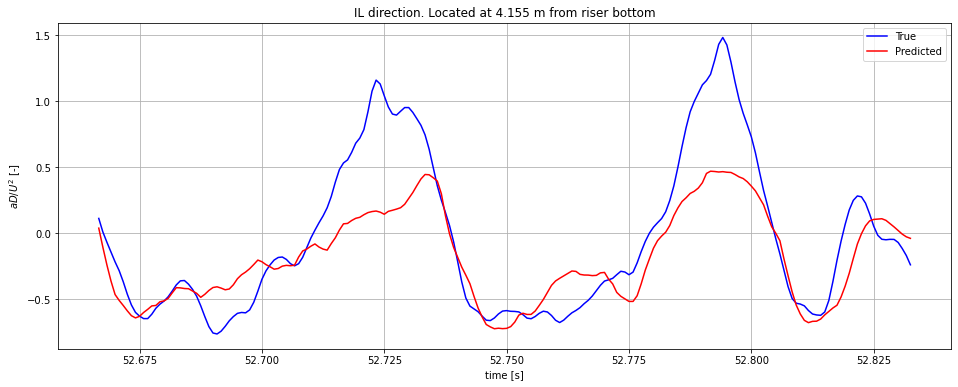

In [69]:
n=10
p=0

if p>= 8:
    dir = 'CF'
else:
    dir= 'IL'

plt.figure(figsize=(16,6))
plt.plot(t_test[n,:],y_test[n,:,p],'b-',label='True')
plt.plot(t_test[n,:],y_pred[n,:,p],'r-',label='Predicted')
plt.legend()
plt.ylabel('$aD/U^2$ [-]')
plt.xlabel('time [s]')
plt.title(f'{dir} direction. Located at {acc_pos[p%8]} m from riser bottom')
plt.grid()
plt.show()

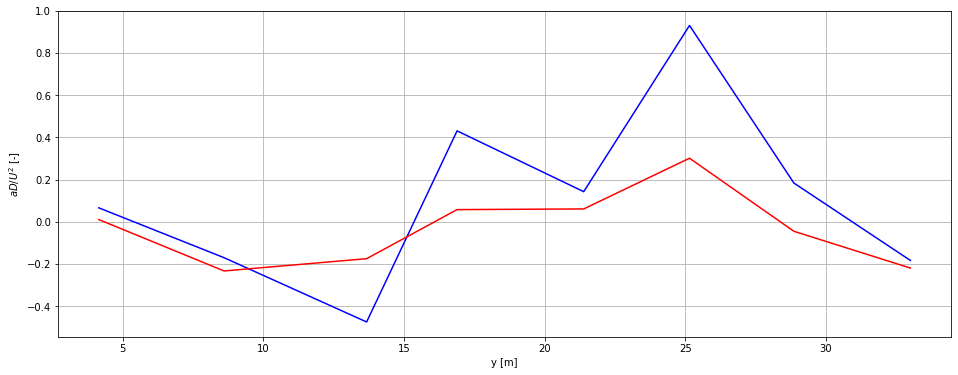

In [70]:
n=200
T=1
plt.figure(figsize=(16,6))
[plt.plot(acc_pos,y_test[n,it,0:8],'b-',label='True') for it in range(T)]
[plt.plot(acc_pos,y_pred[n,it,0:8],'r-',label='Predicted') for it in range(T)]
#plt.legend()
plt.ylabel('$aD/U^2$ [-]')
plt.xlabel('y [m]')
plt.grid()
plt.show()

### Predicting IL and CF separately

In [71]:
X_train_CF = X_train[:,:,40:]
X_val_CF = X_val[:,:,40:]
X_test_CF = X_test[:,:,40:]
y_train_CF = y_train[:,:,8:]
y_val_CF = y_val[:,:,8:]
y_test_CF = y_test[:,:,8:]

n_features = X_train_CF.shape[2]
n_outputs = y_train_CF.shape[2]

print(f'X-shape: (batches, time steps in batch, features) = {X_train_CF.shape}')
print(f'Y-shape: (batches, time steps in batch, output) = {y_train_CF.shape}')

X-shape: (batches, time steps in batch, features) = (3051, 200, 24)
Y-shape: (batches, time steps in batch, output) = (3051, 200, 8)


In [73]:
# Regression
model_CF = Sequential(name='LSTM')
model_CF.add(LSTM(
    units=100,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True,
    dropout=0.1,
    recurrent_dropout=0.1,
    activation='tanh'))
model_CF.add(Dense(50,activation='tanh'))
model_CF.add(Dropout(0.2))
model_CF.add(Dense(n_outputs, activation='linear'))

model_CF.summary()
model_CF.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mean_squared_error'])

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 200, 100)          50000     
_________________________________________________________________
dense_6 (Dense)              (None, 200, 50)           5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 200, 8)            408       
Total params: 55,458
Trainable params: 55,458
Non-trainable params: 0
_________________________________________________________________


In [74]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_CF.fit(X_train_CF,y_train_CF,epochs=100,callbacks=callback,validation_data=(X_val_CF, y_val_CF),validation_steps=10,verbose=True)

Epoch 1/100
96/96 [==============================] - 19s 178ms/step - loss: 0.3973 - mean_squared_error: 0.3973 - val_loss: 0.3389 - val_mean_squared_error: 0.3389
Epoch 2/100
96/96 [==============================] - 27s 283ms/step - loss: 0.2100 - mean_squared_error: 0.2100 - val_loss: 0.2738 - val_mean_squared_error: 0.2738
Epoch 3/100
96/96 [==============================] - 28s 296ms/step - loss: 0.1662 - mean_squared_error: 0.1662 - val_loss: 0.2435 - val_mean_squared_error: 0.2435
Epoch 4/100
96/96 [==============================] - 32s 335ms/step - loss: 0.1436 - mean_squared_error: 0.1436 - val_loss: 0.2245 - val_mean_squared_error: 0.2245
Epoch 5/100
96/96 [==============================] - 29s 306ms/step - loss: 0.1301 - mean_squared_error: 0.1301 - val_loss: 0.2137 - val_mean_squared_error: 0.2137
Epoch 6/100
96/96 [==============================] - 28s 289ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - val_loss: 0.2080 - val_mean_squared_error: 0.2080
Epoch 7/100
96/9

In [77]:
y_pred_CF = model_CF.predict(X_test_CF)

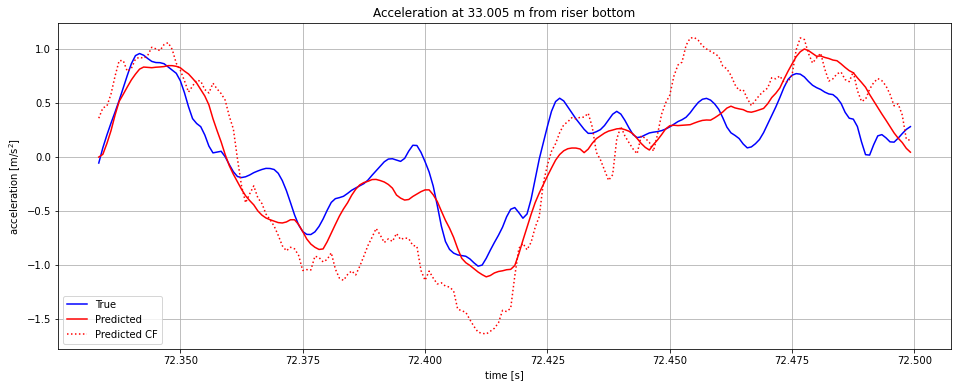

In [78]:
n=128
p=7
plt.figure(figsize=(16,6))
plt.plot(t_test[n,:],y_test[n,:,p+8],'b-',label='True')
plt.plot(t_test[n,:],y_pred[n,:,p+8],'r-',label='Predicted')
plt.plot(t_test[n,:],y_pred_CF[n,:,p],'r:',label='Predicted CF')
plt.legend()
plt.ylabel('acceleration [m/s$^2$]')
plt.xlabel('time [s]')
plt.title(f'Acceleration at {acc_pos[p]} m from riser bottom')
plt.grid()
plt.show()